In [ ]:
# Run this cell to mount your drive to this notebook in order to read the datasets
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

## Read Dataset

In [ ]:
# Put the folder path where the datasets are located
PATH = "drive/My Drive/Colab Notebooks/Project #1/"

In [ ]:
# Read the train and test set with read_csv() method of pandas
train = pd.read_csv(PATH + "train.csv")
test = pd.read_csv(PATH + "test.csv")

In [ ]:
# Display the training dataframe
train.head(5)

,Unnamed: 0,text,label
0,0,I came here and left a review before but last ...,1
1,1,Had a very nice first visit here. The owner Te...,4
2,2,This is a gorgeous and very clean hotel. We h...,4
3,3,The gym is dirty. I have given up. Locker ro...,1
4,4,"The food here is delicious, fast, and consiste...",5


## Preprocess Dataset

In [ ]:
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Define a function to perform preprocessing. This function can perform things like lowercasing, stemming, removing stopwords, etc.

def preprocess(text: str):

  text = text.lower()
  stop_words = set(stopwords.words("english"))
  stop_words.add('n\'t')
  stop_words.add('\'m')
  stop_words.add('\'s')
  stop_words.add('\'ve')
  stop_words.add('\'ll')
  stop_words.add('\'re')
  word_tokens = word_tokenize(text)

 
  stemmer = PorterStemmer()

  # remove the stopwords and stem the words by using PorterStemmer
  clean_text = []
  for word in word_tokens:
    if word not in stop_words:
      if len(word) > 1:
        clean_word = stemmer.stem(word)
        clean_text.append(clean_word)

  return " ".join(clean_text)

In [ ]:
# Apply your preprocessing function to your text fields.

train.text = train.text.apply(preprocess)
test.text = test.text.apply(preprocess)

train.shape, test.shape

((18000, 3), (2000, 3))

In [ ]:
train.head(5)

,Unnamed: 0,text,label
0,0,came left review last time get food poison unl...,1
1,1,nice first visit owner ted friendli start rest...,4
2,2,gorgeou clean hotel room west wing first chore...,4
3,3,gym dirti given locker room total dirti manag ...,1
4,4,food delici fast consist everi singl time gene...,5


In [ ]:
# Create your binary and multiclass datasets

# For binary dataset, get rid of the class 3 in the dataset and map class 1 and 2 to 0, and class 4 and 5 to 1
train_binary = train
test_binary = test

# Function for mapping values; 1 & 2 --> 0, 4 & 5 --> 1
target_mapping_binary = {1: 0,
                  2: 0, 
                  4: 1, 
                  5: 1}

# Turn train data into binary format
train_binary = train_binary.drop(train_binary[train_binary.label == 3].index)
train_binary["label"] = train_binary["label"].map(lambda x: target_mapping_binary[x])

# Turn train data into binary format
test_binary = test_binary.drop(test_binary[test_binary.label == 3].index)
test_binary["label"] = test_binary["label"].map(lambda x: target_mapping_binary[x])


# -----------------------------------------------------------------------------------------------------------------------------------------------
# For multiclass dataset, make sure your classes starts from 0 and goes until 4. (5->4, 4->3, 3->2, 2->1, 1->0)
train_multi = train
test_multi = test

# Function for mapping values; 5 --> 4, 4 --> 3, 3 --> 2, 2 --> 1, 1 --> 0
target_mapping_multi = {1: 0,
                         2: 1,
                         3: 2, 
                         4: 3, 
                         5: 4}

# Turn train data into multi class format
train_multi["label"] = train_multi["label"].map(lambda x: target_mapping_multi[x])

# Turn test data into multi class format
test_multi["label"] = test_multi["label"].map(lambda x: target_mapping_multi[x])

# -----------------------------------------------------------------------------------------------------------------------------------------------
# Print binary and multiclass train and test dataframes
train_binary.head(5), test_binary.head(5), train_multi.head(5), test_multi.head(5)

(   Unnamed: 0                                               text  label
 0           0  came left review last time get food poison unl...      0
 1           1  nice first visit owner ted friendli start rest...      1
 2           2  gorgeou clean hotel room west wing first chore...      1
 3           3  gym dirti given locker room total dirti manag ...      0
 4           4  food delici fast consist everi singl time gene...      1,
    Unnamed: 0                                               text  label
 0           0  stay weekend made stay pleasant locat great sp...      1
 1           1  forev call upon delici design whenev need tast...      1
 2           2  person order homicid boneless regular absolut ...      1
 3           3  eat pretti much everytim go tarpon spring staf...      1
 5           5  great hidden tavern grill wonder old place ear...      1,
    Unnamed: 0                                               text  label
 0           0  came left review last time get fo

In [ ]:
# Train Binary
train_binary_x = train_binary["text"]
train_binary_y = train_binary["label"]

# Train Multiclass
train_multi_x = train_multi["text"]
train_multi_y = train_multi["label"]

# -----------------------------------------------------------------------------------------------------------------------------------------------

# Test Binary
test_multi_x = test_multi["text"]
test_multi_y = test_multi["label"]

# Test Multiclass
test_binary_x = test_binary["text"]
test_binary_y = test_binary["label"]

# Models

## Non-Neural Models

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score,confusion_matrix,accuracy_score

### Naive Bayes


#### Initializing the Pipeline and GridSearchCV Parameters

In [ ]:
from numpy.lib.function_base import average
# https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html

# Create a class for converting sparse matrix output of TfidfVectorizer to dense matrix for feeding into GaussianNB

class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()


# Initiate the pipeline with required components.You can use Pipeline class of sklearn -> https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
# There will be three components; 1) TfidfVectorizer 2) DenseTransformer 3) Naive Bayes classifier.

NB_pipeline = Pipeline([
     ('vectorizer_tfidf', TfidfVectorizer()), 
     ('to_dense', DenseTransformer()), 
     ('classifier_NB', GaussianNB())
])


# Set the hyperparameter space that will be scanned with GridSearchCV.

grid_params_NB = {
  'vectorizer_tfidf__ngram_range': [(1,1), (1,2), (1,3)],
  'vectorizer_tfidf__min_df': [100, 500, 1000]
}

#### Binary

##### Train GridSearchCV with Binary Classification Dataset 

In [ ]:
%%time
# Train Binary Classification
# Initialize and run the GridSearchCV to scan the hyperparameter and find the best hyperparameter set that will maximize the scoring option for binary classification.
grid_search_NB_Binary = GridSearchCV(
                 NB_pipeline,
                 grid_params_NB, 
                 cv=5,
                 verbose=1, 
                 scoring='f1_macro')


# Fit binary dataset to the grid_search_NB
grid_search_NB_Binary.fit(train_binary_x, train_binary_y)
print(grid_search_NB_Binary.cv_results_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
{'mean_fit_time': array([1.09800296, 1.75072818, 3.05007677, 0.54481544, 1.73659186,
       2.93997054, 0.5206573 , 1.6194633 , 2.89493666]), 'std_fit_time': array([0.56159492, 0.01766732, 0.0280571 , 0.01164694, 0.16291979,
       0.04022072, 0.0072968 , 0.02007778, 0.01669117]), 'mean_score_time': array([0.20597191, 0.29165244, 0.41788597, 0.12075896, 0.24511776,
       0.37006927, 0.11626983, 0.23530316, 0.36091919]), 'std_score_time': array([0.05365202, 0.00945326, 0.00629129, 0.00287836, 0.00649322,
       0.00543085, 0.00482167, 0.0047043 , 0.01068762]), 'param_vectorizer_tfidf__min_df': masked_array(data=[100, 100, 100, 500, 500, 500, 1000, 1000, 1000],
             mask=[False, False, False, False, False, False, False, False,
                   False],
       fill_value='?',
            dtype=object), 'param_vectorizer_tfidf__ngram_range': masked_array(data=[(1, 1), (1, 2), (1, 3), (1, 1), (1, 2), (1, 3), (1, 1),
     

##### Report the Results

In [ ]:
# Report the standart deviation of split scores for each hyperparameter group.
# Report the mean and standard deviation of scores for each parameter group.
for i in range(9):
  print("Parameter Group ", i+1)
  print("Parameters: ", grid_search_NB_Binary.cv_results_['params'][i])
  print("Mean Test Score: ", grid_search_NB_Binary.cv_results_['mean_test_score'][i])
  print("Standard Deviation Test Score: ", grid_search_NB_Binary.cv_results_['std_test_score'][i])
  print("Min: ", min(grid_search_NB_Binary.cv_results_["split0_test_score"][i], grid_search_NB_Binary.cv_results_["split1_test_score"][i],
                     grid_search_NB_Binary.cv_results_["split2_test_score"][i], grid_search_NB_Binary.cv_results_["split3_test_score"][i],
                     grid_search_NB_Binary.cv_results_["split4_test_score"][i]))
  print("Max: ", max(grid_search_NB_Binary.cv_results_["split0_test_score"][i], grid_search_NB_Binary.cv_results_["split1_test_score"][i],
                     grid_search_NB_Binary.cv_results_["split2_test_score"][i], grid_search_NB_Binary.cv_results_["split3_test_score"][i],
                     grid_search_NB_Binary.cv_results_["split4_test_score"][i]))
  print("\n")


# Show the best parameter set for given dataset and hyperparameter space.
print("Best Parameters: ", grid_search_NB_Binary.best_params_)

Parameter Group  1
Parameters:  {'vectorizer_tfidf__min_df': 100, 'vectorizer_tfidf__ngram_range': (1, 1)}
Mean Test Score:  0.8542374043833949
Standard Deviation Test Score:  0.005122799448803231
Min:  0.8462872819793779
Max:  0.8601179471665417


Parameter Group  2
Parameters:  {'vectorizer_tfidf__min_df': 100, 'vectorizer_tfidf__ngram_range': (1, 2)}
Mean Test Score:  0.8600638910720917
Standard Deviation Test Score:  0.007341615443068069
Min:  0.8497549243583071
Max:  0.8719120033225389


Parameter Group  3
Parameters:  {'vectorizer_tfidf__min_df': 100, 'vectorizer_tfidf__ngram_range': (1, 3)}
Mean Test Score:  0.860200781216163
Standard Deviation Test Score:  0.0067386139688290665
Min:  0.8497549243583071
Max:  0.8705205202491479


Parameter Group  4
Parameters:  {'vectorizer_tfidf__min_df': 500, 'vectorizer_tfidf__ngram_range': (1, 1)}
Mean Test Score:  0.8130507007904967
Standard Deviation Test Score:  0.0036206581525370014
Min:  0.8073562350927301
Max:  0.8174835487027747


Par

##### Setting Pipeline with Best Parameters and Making Prediction




In [ ]:
# Building the pipeline with the best parameter group and reporting Conf. Mat. and Results on the Test Set
# Create your Pipeline object with the best parameter set.
NB_Binary_BestParams_Pipeline = Pipeline([
     ('vectorizer_tfidf', TfidfVectorizer(ngram_range=(1,2), min_df=100)), 
     ('to_dense', DenseTransformer()), 
     ('classifier_NB', GaussianNB())
])


# Fit your pipeline on training set.
BestParams_NB_Binary_Model = NB_Binary_BestParams_Pipeline.fit(train_binary_x, train_binary_y)


# Make prediction
y_Predict_NB_Binary = BestParams_NB_Binary_Model.predict(test_binary_x)

##### Reporting the Scores and Confusion Matrix for Binary Classification

In [ ]:
# Report the F1 and Accuracy and Confusion Matrix scores for binary classification
Accuracy_NB_Binary_Test_BestParams = accuracy_score(test_binary_y, y_Predict_NB_Binary)
F1_NB_Binary_Test_BestParams = f1_score(test_binary_y, y_Predict_NB_Binary, average='macro')

print('F1 Macro for Binary Classification with Best Parameters:\n', F1_NB_Binary_Test_BestParams)
print('\nAccuracy Score for Binary Classification with Best Parameters:\n', Accuracy_NB_Binary_Test_BestParams)
print('\nConfusion Matrix:')
confusion_matrix(test_binary_y, y_Predict_NB_Binary)

F1 Macro for Binary Classification with Best Parameters:
 0.8687712178561673

Accuracy Score for Binary Classification with Best Parameters:
 0.8688010043942247

Confusion Matrix:


array([[680,  93],
       [116, 704]])

#### Multi

##### Train GridSearchCV with Multiclass Classification Dataset 

In [ ]:
%%time
# Train Multiclass Classification
# Initialize and run the GridSearchCV to scan the hyperparameter and find the best hyperparameter set that will maximize the scoring option for multiclass classification.
grid_search_NB_Multi = GridSearchCV(
                 NB_pipeline,
                 grid_params_NB, 
                 cv=5,
                 verbose=1, 
                 scoring='f1_macro')


# Fit multiclass dataset to the grid_search_NB
grid_search_NB_Multi.fit(train_multi_x, train_multi_y)
print(grid_search_NB_Multi.cv_results_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
{'mean_fit_time': array([0.8925344 , 2.20540662, 4.24301386, 0.68350182, 2.00145941,
       3.86936245, 0.65147934, 2.23390021, 3.70643892]), 'std_fit_time': array([0.03762168, 0.02255642, 0.7811531 , 0.00725528, 0.03718182,
       0.31773042, 0.01558628, 0.48130737, 0.06185982]), 'mean_score_time': array([0.30991936, 0.47574139, 0.6322103 , 0.17763729, 0.33265028,
       0.49877515, 0.15736046, 0.32141318, 0.48121061]), 'std_score_time': array([0.00729149, 0.01026245, 0.01448725, 0.00877463, 0.01173344,
       0.02406921, 0.0065055 , 0.01280232, 0.0181068 ]), 'param_vectorizer_tfidf__min_df': masked_array(data=[100, 100, 100, 500, 500, 500, 1000, 1000, 1000],
             mask=[False, False, False, False, False, False, False, False,
                   False],
       fill_value='?',
            dtype=object), 'param_vectorizer_tfidf__ngram_range': masked_array(data=[(1, 1), (1, 2), (1, 3), (1, 1), (1, 2), (1, 3), (1, 1),
     

##### Report the Results

In [ ]:
# Report the standart deviation of split scores for each hyperparameter group.
# Report the max, min, mean, and standard deviation of scores for each parameter group.
for i in range(9):
  print("Parameter Group ", i+1)
  print("Parameters: ", grid_search_NB_Multi.cv_results_['params'][i])
  print("Mean Test Score: ", grid_search_NB_Multi.cv_results_['mean_test_score'][i])
  print("Standard Deviation Test Score: ", grid_search_NB_Multi.cv_results_['std_test_score'][i])
  print("Min: ", min(grid_search_NB_Multi.cv_results_["split0_test_score"][i], grid_search_NB_Multi.cv_results_["split1_test_score"][i],
                     grid_search_NB_Multi.cv_results_["split2_test_score"][i], grid_search_NB_Multi.cv_results_["split3_test_score"][i],
                     grid_search_NB_Multi.cv_results_["split4_test_score"][i]))
  print("Max: ", max(grid_search_NB_Multi.cv_results_["split0_test_score"][i], grid_search_NB_Multi.cv_results_["split1_test_score"][i],
                     grid_search_NB_Multi.cv_results_["split2_test_score"][i], grid_search_NB_Multi.cv_results_["split3_test_score"][i],
                     grid_search_NB_Multi.cv_results_["split4_test_score"][i]))
  print("\n")


# Show the best parameter set for given dataset and hyperparameter space.
print("Best Parameters: ", grid_search_NB_Multi.best_params_)

Parameter Group  1
Parameters:  {'vectorizer_tfidf__min_df': 100, 'vectorizer_tfidf__ngram_range': (1, 1)}
Mean Test Score:  0.4445012872862179
Standard Deviation Test Score:  0.007110661446049768
Min:  0.4305396111761393
Max:  0.4502131932296366


Parameter Group  2
Parameters:  {'vectorizer_tfidf__min_df': 100, 'vectorizer_tfidf__ngram_range': (1, 2)}
Mean Test Score:  0.4561186691168338
Standard Deviation Test Score:  0.007752963984642025
Min:  0.4444113254577638
Max:  0.4669184291625168


Parameter Group  3
Parameters:  {'vectorizer_tfidf__min_df': 100, 'vectorizer_tfidf__ngram_range': (1, 3)}
Mean Test Score:  0.4567319032363632
Standard Deviation Test Score:  0.00815789056184797
Min:  0.4439244395806406
Max:  0.467845173574052


Parameter Group  4
Parameters:  {'vectorizer_tfidf__min_df': 500, 'vectorizer_tfidf__ngram_range': (1, 1)}
Mean Test Score:  0.4521197195064187
Standard Deviation Test Score:  0.009624668608540174
Min:  0.4349925882462452
Max:  0.46243629865916047


Param

##### Setting Pipeline with Best Parameters and Making Prediction

In [ ]:
# Building the pipeline with the best parameter group and reporting Conf. Mat. and Results on the Test Set
# Create your Pipeline object with the best parameter set.
NB_Multi_BestParams_Pipeline = Pipeline([
     ('vectorizer_tfidf', TfidfVectorizer(ngram_range=(1,3), min_df=100)), 
     ('to_dense', DenseTransformer()), 
     ('classifier_NB', GaussianNB())
])


# Fit your pipeline on training set.
BestParams_NB_Multi_Model = NB_Multi_BestParams_Pipeline.fit(train_multi_x, train_multi_y)


# Make prediction
y_Predict_NB_Multi = BestParams_NB_Multi_Model.predict(test_multi_x)

##### Reporting the Scores and Confusion Matrix for Multiclass Classification

In [ ]:
# Report the F1 and Accuracy scores and Confusion Matrix for multiclass classification
Accuracy_NB_Multi_Test_BestParams = accuracy_score(test_multi_y, y_Predict_NB_Multi)
F1_NB_Multi_Test_BestParams = f1_score(test_multi_y, y_Predict_NB_Multi, average='macro')

print('F1 Macro for Multiclass Classification with Best Parameters:\n', F1_NB_Multi_Test_BestParams)
print('\nAccuracy Score for Multiclass Classification with Best Parameters:\n', Accuracy_NB_Multi_Test_BestParams)
print('\nConfusion Matrix:')
confusion_matrix(test_multi_y, y_Predict_NB_Multi)

F1 Macro for Multiclass Classification with Best Parameters:
 0.47526559258349055

Accuracy Score for Multiclass Classification with Best Parameters:
 0.4915

Confusion Matrix:


array([[264,  91,  18,   5,  15],
       [ 96, 156,  73,  21,  34],
       [ 46,  78, 116,  95,  72],
       [ 20,  32,  60, 133, 134],
       [ 26,  13,  19,  69, 314]])

### Logistic Regression

#### Initializing the Pipeline and GridSearchCV Parameters

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

# Initiate the pipeline with required components.You can use Pipeline class of sklearn -> https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
# There will be two components; 1) Word weightning 2) Logistic Regression classifier.
LR_pipeline = Pipeline([
     ('vectorizer_tfidf', TfidfVectorizer()), 
     ('classifier_LR', LogisticRegression(random_state=22))
])


#Set the hyperparameter space that will be scanned.
grid_params_LR = {
  'vectorizer_tfidf__ngram_range': [(1,1), (1,2), (1,3)],
  'vectorizer_tfidf__min_df': [100, 500, 1000],
  'classifier_LR__l1_ratio': [0.0, 0.5, 1.0]
}

#### Binary

##### Train GridSearchCV with Binary Classification Dataset

In [ ]:
%%time
# Initialize and run the GridSearchCV to scan the hyperparameter and find the best hyperparameter set that will maximize the scoring option for binary classification.
grid_search_LR_Binary = GridSearchCV(
                 LR_pipeline, 
                 grid_params_LR, 
                 cv = 5,
                 verbose = 1, 
                 scoring = 'f1_macro') 

# Fit binary dataset to the grid_search_LR
grid_search_LR_Binary.fit(train_binary_x, train_binary_y)
print(grid_search_LR_Binary.cv_results_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
{'mean_fit_time': array([0.64763546, 1.63877077, 2.78068924, 0.58505406, 1.59826751,
       3.35907249, 0.52542706, 1.53013873, 2.96164875, 1.4102571 ,
       1.79597039, 3.49111981, 0.67839761, 3.974506  , 4.45213137,
       1.02990761, 3.28383846, 2.81683698, 0.66542273, 1.67287664,
       2.96072183, 0.58706584, 2.85808315, 4.9504385 , 0.54023175,
       1.63738976, 2.87119451]), 'std_fit_time': array([0.01533409, 0.0306092 , 0.02977441, 0.00894899, 0.02273817,
       0.83727759, 0.01219222, 0.01661217, 0.43576528, 0.21391453,
       0.32555714, 0.70638149, 0.15033251, 1.21727029, 0.807752  ,
       0.03470546, 1.03823062, 0.13780498, 0.09514831, 0.01063843,
       0.03839308, 0.02070404, 1.09406188, 1.82007664, 0.01343624,
       0.00593452, 0.04047213]), 'mean_score_time': array([0.11841493, 0.240558  , 0.36175218, 0.11270795, 0.22927389,
       0.41183224, 0.10938854, 0.22329588, 0.41932635, 0.33311381,
       0.232904

##### Report the Results

In [ ]:
# Report the standart deviation of split scores for each hyperparameter group.
for i in range(27):
  print("Parameter Group ", i+1)
  print("Parameters: ", grid_search_LR_Binary.cv_results_['params'][i])
  print("Mean Test Score: ", grid_search_LR_Binary.cv_results_['mean_test_score'][i])
  print("Standard Deviation Test Score: ", grid_search_LR_Binary.cv_results_['std_test_score'][i])
  print("Min: ", min(grid_search_LR_Binary.cv_results_["split0_test_score"][i], grid_search_LR_Binary.cv_results_["split1_test_score"][i],
                     grid_search_LR_Binary.cv_results_["split2_test_score"][i], grid_search_LR_Binary.cv_results_["split3_test_score"][i],
                     grid_search_LR_Binary.cv_results_["split4_test_score"][i]))
  print("Max: ", max(grid_search_LR_Binary.cv_results_["split0_test_score"][i], grid_search_LR_Binary.cv_results_["split1_test_score"][i],
                     grid_search_LR_Binary.cv_results_["split2_test_score"][i], grid_search_LR_Binary.cv_results_["split3_test_score"][i],
                     grid_search_LR_Binary.cv_results_["split4_test_score"][i]))
  print("\n")


# Show the best parameter set for given dataset and hyperparameter space.
print("Best Parameters: ", grid_search_LR_Binary.best_params_)

Parameter Group  1
Parameters:  {'classifier_LR__l1_ratio': 0.0, 'vectorizer_tfidf__min_df': 100, 'vectorizer_tfidf__ngram_range': (1, 1)}
Mean Test Score:  0.9039270734505316
Standard Deviation Test Score:  0.0035760217266048873
Min:  0.8993329265636055
Max:  0.9100978866625582


Parameter Group  2
Parameters:  {'classifier_LR__l1_ratio': 0.0, 'vectorizer_tfidf__min_df': 100, 'vectorizer_tfidf__ngram_range': (1, 2)}
Mean Test Score:  0.9053172864559327
Standard Deviation Test Score:  0.004469668842880747
Min:  0.9014178791573693
Max:  0.9135706352037654


Parameter Group  3
Parameters:  {'classifier_LR__l1_ratio': 0.0, 'vectorizer_tfidf__min_df': 100, 'vectorizer_tfidf__ngram_range': (1, 3)}
Mean Test Score:  0.9052478213686159
Standard Deviation Test Score:  0.004341727994197243
Min:  0.9014178791573693
Max:  0.9132233097671819


Parameter Group  4
Parameters:  {'classifier_LR__l1_ratio': 0.0, 'vectorizer_tfidf__min_df': 500, 'vectorizer_tfidf__ngram_range': (1, 1)}
Mean Test Score: 

##### Setting Pipeline with Best Parameters and Making Prediction

In [ ]:
# Building the pipeline with the best parameter group and reporting Conf. Mat. and Results on the Test Set #
#Create your pipeline object with the best parameter set.
LR_Binary_BestParams_Pipeline = Pipeline([
     ('vectorizer_tfidf', TfidfVectorizer(ngram_range=(1,2), min_df=100)), 
     ('classifier_LR', LogisticRegression(random_state=22, l1_ratio=0.0))
])


#Fit your pipeline on training set.
BestParams_LR_Binary_Model = LR_Binary_BestParams_Pipeline.fit(train_binary_x, train_binary_y)


# Make prediction
y_Predict_LR_Binary = BestParams_LR_Binary_Model.predict(test_binary_x)

##### Reporting the Scores and Confusion Matrix for Binary Classification

In [ ]:
# Report the F1 and Accuracy scores and Confusion Matrix for binary classification
F1_LR_Binary_Test_BestParams = f1_score(test_binary_y, y_Predict_LR_Binary, average='macro')
Accuracy_LR_Binary_Test_BestParams = accuracy_score(test_binary_y, y_Predict_LR_Binary)

print('F1 Macro for Binary Classification with Best Parameters:\n', F1_LR_Binary_Test_BestParams)
print('\nAccuracy Score for Binary Classification with Best Parameters:\n', Accuracy_LR_Binary_Test_BestParams)
print('\nConfusion Matrix:')
confusion_matrix(test_binary_y, y_Predict_LR_Binary)

F1 Macro for Binary Classification with Best Parameters:
 0.908329917386643

Accuracy Score for Binary Classification with Best Parameters:
 0.9083490269930948

Confusion Matrix:


array([[712,  61],
       [ 85, 735]])

#### Multi

##### Train GridSearchCV with Multiclass Classification Dataset

In [ ]:
%%time
# Initialize and run the GridSearchCV to scan the hyperparameter and find the best hyperparameter set that will maximize the scoring option for binary classification.
grid_search_LR_Multi = GridSearchCV(
                 LR_pipeline, 
                 grid_params_LR, 
                 cv = 5,
                 verbose = 1, 
                 scoring = 'f1_macro') 

# Fit binary dataset to the grid_search_LR
grid_search_LR_Multi.fit(train_multi_x, train_multi_y)
print(grid_search_LR_Multi.cv_results_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
{'mean_fit_time': array([2.3475028 , 3.76614108, 5.45782189, 1.97816172, 3.30320883,
       4.98713923, 1.70531092, 2.97863789, 4.60367241, 2.32767959,
       3.75832238, 5.35163207, 1.97474499, 3.30628633, 5.01560545,
       1.68397498, 3.01344953, 4.6164567 , 2.3203784 , 3.76328592,
       5.34449029, 1.97809834, 3.30582199, 4.97688971, 1.68936954,
       2.95064788, 4.51127062]), 'std_fit_time': array([0.024817  , 0.04857463, 0.07609427, 0.02067737, 0.01599347,
       0.09984373, 0.06942438, 0.05752073, 0.06879812, 0.02670958,
       0.04684159, 0.05589676, 0.03618616, 0.02216639, 0.03910853,
       0.06087461, 0.06356805, 0.07989687, 0.03335171, 0.08438838,
       0.10390594, 0.04203685, 0.02367419, 0.06156619, 0.07284807,
       0.04790349, 0.08726635]), 'mean_score_time': array([0.15404725, 0.31617384, 0.49950376, 0.14722528, 0.30519214,
       0.48424697, 0.14863591, 0.30320339, 0.45824723, 0.15800629,
       0.317498

##### Report the Results

In [ ]:
# Report the standart deviation of split scores for each hyperparameter group.
for i in range(27):
  print("Parameter Group ", i+1)
  print(grid_search_LR_Multi.cv_results_['params'][i])
  print(grid_search_LR_Multi.cv_results_['mean_test_score'][i])
  print(grid_search_LR_Multi.cv_results_['std_test_score'][i])
  print("Min: ", min(grid_search_LR_Multi.cv_results_["split0_test_score"][i], grid_search_LR_Multi.cv_results_["split1_test_score"][i],
                     grid_search_LR_Multi.cv_results_["split2_test_score"][i], grid_search_LR_Multi.cv_results_["split3_test_score"][i],
                     grid_search_LR_Multi.cv_results_["split4_test_score"][i]))
  print("Max: ", max(grid_search_LR_Multi.cv_results_["split0_test_score"][i], grid_search_LR_Multi.cv_results_["split1_test_score"][i],
                     grid_search_LR_Multi.cv_results_["split2_test_score"][i], grid_search_LR_Multi.cv_results_["split3_test_score"][i],
                     grid_search_LR_Multi.cv_results_["split4_test_score"][i]))
  print("\n")


# Show the best parameter set for given dataset and hyperparameter space.
print("Best Parameters: ", grid_search_LR_Multi.best_params_)

Parameter Group  1
{'classifier_LR__l1_ratio': 0.0, 'vectorizer_tfidf__min_df': 100, 'vectorizer_tfidf__ngram_range': (1, 1)}
0.533278157858257
0.005151607577326998
Min:  0.5243015182286054
Max:  0.5380659333066168


Parameter Group  2
{'classifier_LR__l1_ratio': 0.0, 'vectorizer_tfidf__min_df': 100, 'vectorizer_tfidf__ngram_range': (1, 2)}
0.536312109663449
0.0049908379275617675
Min:  0.5284286664610763
Max:  0.5434247275415489


Parameter Group  3
{'classifier_LR__l1_ratio': 0.0, 'vectorizer_tfidf__min_df': 100, 'vectorizer_tfidf__ngram_range': (1, 3)}
0.5364166486996111
0.005090054209611724
Min:  0.5280977399670365
Max:  0.5432273768095992


Parameter Group  4
{'classifier_LR__l1_ratio': 0.0, 'vectorizer_tfidf__min_df': 500, 'vectorizer_tfidf__ngram_range': (1, 1)}
0.506878694432378
0.009500533533121237
Min:  0.48907890289351696
Max:  0.5149015726124225


Parameter Group  5
{'classifier_LR__l1_ratio': 0.0, 'vectorizer_tfidf__min_df': 500, 'vectorizer_tfidf__ngram_range': (1, 2)}
0.5

##### Setting Pipeline with Best Parameters and Making Prediction

In [ ]:
# Building the pipeline with the best parameter group and reporting Conf. Mat. and Results on the Test Set
#Create your pipeline object with the best parameter set.
LR_Multi_BestParams_Pipeline = Pipeline([
     ('vectorizer_tfidf', TfidfVectorizer(ngram_range=(1,2), min_df=100)), 
     ('classifier_LR', LogisticRegression(random_state=22, l1_ratio=0.0))
])


#Fit your pipeline on training set.
BestParams_LR_Multi_Model = LR_Multi_BestParams_Pipeline.fit(train_multi_x, train_multi_y)


# Make prediction
y_Predict_LR_Multi = BestParams_LR_Multi_Model.predict(test_multi_x)

##### Reporting the Scores and Confusion Matrix for Multiclass Classification

In [ ]:
# Report the F1 and Accuracy scores and Confusion Matrix for multiclass classification
F1_LR_Multi_Test_BestParams = f1_score(test_multi_y, y_Predict_LR_Multi, average='macro')
Accuracy_LR_Multi_Test_BestParams = accuracy_score(test_multi_y, y_Predict_LR_Multi)

print('F1 Macro for Multiclass Classification with Best Parameters:\n', F1_LR_Multi_Test_BestParams)
print('\nAccuracy Score for Multiclass Classification with Best Parameters:\n', Accuracy_LR_Multi_Test_BestParams)
print('\nConfusion Matrix:')
confusion_matrix(test_multi_y, y_Predict_LR_Multi)

F1 Macro for Multiclass Classification with Best Parameters:
 0.5537120257977514

Accuracy Score for Multiclass Classification with Best Parameters:
 0.557

Confusion Matrix:


array([[278,  89,  14,   6,   6],
       [ 83, 189,  79,  18,  11],
       [ 26,  83, 187,  91,  20],
       [ 12,  27,  72, 171,  97],
       [  9,  11,  21, 111, 289]])

## Neural Models

Helpful Resource About the Whole CNN Sentence Classification Process: 
<br>
https://cnvrg.io/cnn-sentence-classification/

### Convolutional Neural Network (CNN)

#### Libraries

In [ ]:
import pandas as pd
import numpy as np
import nltk,re
import tensorflow as tf
tf.config.experimental_run_functions_eagerly(True)
from sklearn.model_selection import train_test_split
from numpy import array,asarray,zeros

from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize
import nltk
nltk.download('punkt')

import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras.layers.convolutional import Conv1D,MaxPooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import Dense,Flatten,Embedding,Input,Dropout
from keras.callbacks import ModelCheckpoint

from tensorflow.keras.utils import to_categorical

from gensim.models import Word2Vec
import gensim.downloader as api
import string

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### Preparing Datasets and Creating the Validation Datasets

In [ ]:
# Create a validation set from train set
# Please use random_state of 22 and test_size of 0.1
# ==================================================

# CNN Validation Binary
x_train_binary_cnn, x_val_binary_cnn, y_train_binary_cnn, y_val_binary_cnn = train_test_split(train_binary["text"], train_binary["label"], test_size=0.1, random_state= 22)

x_test_binary_cnn, y_test_binary_cnn = test_binary["text"], test_binary["label"]


# CNN Validation Multiclass
x_train_multi_cnn, x_val_multi_cnn, y_train_multi_cnn, y_val_multi_cnn = train_test_split(train_multi["text"], train_multi["label"], test_size=0.1, random_state= 22)

x_test_multi_cnn, y_test_multi_cnn = test_multi["text"], test_multi["label"]


# Arranging y-values of the multiclass datasets using "to_categorical"
y_train_multi_cnn_p = to_categorical(y_train_multi_cnn)
y_test_multi_cnn_p = to_categorical(y_test_multi_cnn)
y_val_multi_cnn_p = to_categorical(y_val_multi_cnn)

#### Length of the Longest Sentences

In [ ]:
# Find the length of the longest sentences
# ========================================

ultimate_dataset = train["text"].append(test["text"], ignore_index = True)

# Length of the longest sentences 
max_sent_len = max(len(i.split()) for i in ultimate_dataset)

# General variable for the "Length of the Longest Sentences"
MAX_LENGTH_SENT = max_sent_len
print("Length of the Longest Sentences: ", MAX_LENGTH_SENT)

Length of the Longest Sentences:  495


#### Tokenization


In [ ]:
# Initialize and apply "Tokenizers" to the data
# =============================================

# Binary
# -----------------------------------------------------------------------------------------------------------------------------------------------
tokenizer_keras_binary = Tokenizer(filters='!"$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'')
tokenizer_keras_binary.fit_on_texts(list(x_train_binary_cnn))

# Train
x_train_binary_cnn_tok = tokenizer_keras_binary.texts_to_sequences(x_train_binary_cnn)

# Test
x_test_binary_cnn_tok = tokenizer_keras_binary.texts_to_sequences(x_test_binary_cnn)

# Validation
x_val_binary_cnn_tok = tokenizer_keras_binary.texts_to_sequences(x_val_binary_cnn)



# Multiclass
# -----------------------------------------------------------------------------------------------------------------------------------------------
tokenizer_keras_multi = Tokenizer(filters='!"$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'')
tokenizer_keras_multi.fit_on_texts(list(x_train_multi_cnn))

# Train
x_train_multi_cnn_tok = tokenizer_keras_multi.texts_to_sequences(x_train_multi_cnn)

# Test
x_test_multi_cnn_tok = tokenizer_keras_multi.texts_to_sequences(x_test_multi_cnn)

# Validation
x_val_multi_cnn_tok = tokenizer_keras_multi.texts_to_sequences(x_val_multi_cnn)

#### Padding

##### Binary

In [ ]:
# Train
#-----------------
padded_train_binary_x = pad_sequences(x_train_binary_cnn_tok, padding='post', maxlen=MAX_LENGTH_SENT)

# Test
#----------------
padded_test_binary_x = pad_sequences(x_test_binary_cnn_tok, padding='post', maxlen=MAX_LENGTH_SENT)

# Validation
#----------------
padded_val_binary_x = pad_sequences(x_val_binary_cnn_tok, padding='post', maxlen=MAX_LENGTH_SENT)

##### Multiclass

In [ ]:
# Train
#-----------------
padded_train_multi_x = pad_sequences(x_train_multi_cnn_tok, padding='post', maxlen=MAX_LENGTH_SENT)
# -----------------------------------------------------------------------------------------------------------------------------------------------

# Test
#----------------
padded_test_multi_x = pad_sequences(x_test_multi_cnn_tok, padding='post', maxlen=MAX_LENGTH_SENT)
# -----------------------------------------------------------------------------------------------------------------------------------------------

# Validation
#----------------
padded_val_multi_x = pad_sequences(x_val_multi_cnn_tok, padding='post', maxlen=MAX_LENGTH_SENT)
# -----------------------------------------------------------------------------------------------------------------------------------------------

#### Word Embeddings

##### Script for Getting the F1 Score of the Models

Resource: https://aakashgoel12.medium.com/how-to-add-user-defined-function-get-f1-score-in-keras-metrics-3013f979ce0d#:~:text=You%20will%20get%20training%20and%20validation%20F1%20score%20after%20each%20epoch.&text=By%20default%2C%20f1%20score%20is,like%20accuracy%2C%20categorical%20accuracy%20etc.

In [ ]:
import keras.backend as K

def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

##### Creating Embedding Layers


In [ ]:
# Embedding Layer For Randomly Initialized Word Embeddings
# ========================================================

# Binary
random_emb_layer_binary = Embedding(input_dim=len(tokenizer_keras_binary.word_index)+1, output_dim=100, input_length=MAX_LENGTH_SENT)
# Multiclass
random_emb_layer_multi = Embedding(input_dim=len(tokenizer_keras_multi.word_index)+1, output_dim=100, input_length=MAX_LENGTH_SENT)



# Word2Vec Embedding Layer For Word Embeddings From Scratch
# =========================================================

# Binary
my_binary_embedding = Word2Vec(sentences=[i.split() for i in x_train_binary_cnn], min_count=1)
my_binary_emb_layer = Embedding(input_dim=len(my_binary_embedding.wv.vocab), output_dim=100, input_length=MAX_LENGTH_SENT, weights=[my_binary_embedding.wv.vectors])
# Multiclass
my_multi_embedding = Word2Vec(sentences=[i.split() for i in x_train_multi_cnn], min_count=1)
my_multi_emb_layer = Embedding(input_dim=len(my_multi_embedding.wv.vocab), output_dim=100, input_length=MAX_LENGTH_SENT, weights=[my_multi_embedding.wv.vectors])



# Word2Vec Embedding Layer For Pretrained Word Embeddings
# =======================================================

# Binary
pretrained_binary_embedding = Word2Vec(sentences=api.load('text8'), min_count=1)
pretrained_binary_emb_layer = Embedding(input_dim=len(pretrained_binary_embedding.wv.vocab), output_dim=100, input_length=MAX_LENGTH_SENT, weights=[pretrained_binary_embedding.wv.vectors])
# Multiclass
pretrained_multi_embedding = Word2Vec(sentences=api.load('text8'), min_count=1)
pretrained_multi_emb_layer = Embedding(input_dim=len(pretrained_multi_embedding.wv.vocab), output_dim=100, input_length=MAX_LENGTH_SENT, weights=[pretrained_multi_embedding.wv.vectors])

[==================================================] 100.0% 31.6/31.6MB downloaded


##### Parameter Vectors for Running the Model Functions

In [ ]:
# General
filter_size_options = [16, 32]
kernel_size_options = [4, 8]
hidden_layer_options =[10, 20]

# Binary
operation_names_binary = ['Random Binary Model', 'From Scratch Binary Model', 'Pretrained Binary Model']
embedding_layer_binary = [random_emb_layer_binary, my_binary_emb_layer, pretrained_binary_emb_layer]

# Multiclass
operation_names_multi = ['Random Multiclass Model', 'From Scratch Multiclass Model', 'Pretrained Multiclass Model']
embedding_layer_multi = [random_emb_layer_multi, my_multi_emb_layer, pretrained_multi_emb_layer]

##### Binary

###### MODEL FUNCTION

In [ ]:
def CNN_Model_Function_Binary(operation_binary, emb_layer_binary, filter_size, kernel_size, hidden_layer_size):
  
  print(operation_binary)
  print("=================================")
  print("Filter Size: ", filter_size)
  print("Kernel Size: ", kernel_size)
  print("Hidden Layer Size: ", hidden_layer_size)
  print("--------------------------------------------------------------------- \n")
    
  # Define Model
  model_binary = Sequential()
  model_binary.add(emb_layer_binary)
  model_binary.add(Conv1D(filters=filter_size, kernel_size=kernel_size, activation='relu'))
  model_binary.add(GlobalMaxPooling1D())
  model_binary.add(Flatten())
  model_binary.add(Dense(hidden_layer_size, activation='relu'))
  model_binary.add(Dense(1, activation='sigmoid'))
  print(model_binary.summary())

  # Compile model
  model_binary.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', get_f1])

  print("\n--------------------------------------------------------------------- \n")

  # Fit
  model_binary.fit(padded_train_binary_x, y_train_binary_cnn, validation_data=(padded_val_binary_x, y_val_binary_cnn), epochs=10, verbose=0)

  # Getting score metrics
  scores_model_binary = model_binary.evaluate(padded_test_binary_x, y_test_binary_cnn, verbose=0)

  print("Accuracy Score: %.2f%%" % (scores_model_binary[1]*100))
  print("F1 Score: %.2f%%" % (scores_model_binary[2]*100))
  print('Confusion Matrix:')
  y_predict_model_binary = model_binary.predict(padded_test_binary_x)
  y_predict_model_binary = y_predict_model_binary.astype(int).tolist()
  print(confusion_matrix(y_test_binary_cnn, y_predict_model_binary))

  print("\n -------------------------------------------------------------------------------------------------------------------- \n")

###### CALL FUNCTION IN LOOP

In [ ]:
# CALL IN LOOP
# Binary
#operation_names_binary = ['Random Binary Model', 'From Scratch Binary Model', 'Pretrained Binary Model']
#embedding_layer_binary = [random_emb_layer_binary, my_binary_emb_layer, pretrained_binary_emb_layer]

# Random Binary Model
for a in range(len(filter_size_options)):
  for b in range(len(kernel_size_options)):
    for c in range(len(hidden_layer_options)):
      CNN_Model_Function_Binary('Random Binary Model', random_emb_layer_binary, filter_size_options[a], kernel_size_options[b], hidden_layer_options[c])

Random Binary Model
Filter Size:  16
Kernel Size:  4
Hidden Layer Size:  10
--------------------------------------------------------------------- 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 495, 100)          2023000   
                                                                 
 conv1d (Conv1D)             (None, 492, 16)           6416      
                                                                 
 global_max_pooling1d (Globa  (None, 16)               0         
 lMaxPooling1D)                                                  
                                                                 
 flatten (Flatten)           (None, 16)                0         
                                                                 
 dense (Dense)               (None, 10)                170       
                                        

In [ ]:
# From Scratch Binary Model
for a in range(len(filter_size_options)):
  for b in range(len(kernel_size_options)):
    for c in range(len(hidden_layer_options)):
      CNN_Model_Function_Binary('From Scratch Binary Model', my_binary_emb_layer, filter_size_options[a], kernel_size_options[b], hidden_layer_options[c])

From Scratch Binary Model
Filter Size:  16
Kernel Size:  4
Hidden Layer Size:  10
--------------------------------------------------------------------- 

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 495, 100)          2522900   
                                                                 
 conv1d_8 (Conv1D)           (None, 492, 16)           6416      
                                                                 
 global_max_pooling1d_8 (Glo  (None, 16)               0         
 balMaxPooling1D)                                                
                                                                 
 flatten_8 (Flatten)         (None, 16)                0         
                                                                 
 dense_16 (Dense)            (None, 10)                170       
                                

In [ ]:
# Pretrained Binary Model
for a in range(len(filter_size_options)):
  for b in range(len(kernel_size_options)):
    for c in range(len(hidden_layer_options)):
      CNN_Model_Function_Binary('Pretrained Binary Model', pretrained_binary_emb_layer, filter_size_options[a], kernel_size_options[b], hidden_layer_options[c])

Pretrained Binary Model
Filter Size:  16
Kernel Size:  4
Hidden Layer Size:  10
--------------------------------------------------------------------- 

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 495, 100)          25385400  
                                                                 
 conv1d_16 (Conv1D)          (None, 492, 16)           6416      
                                                                 
 global_max_pooling1d_16 (Gl  (None, 16)               0         
 obalMaxPooling1D)                                               
                                                                 
 flatten_16 (Flatten)        (None, 16)                0         
                                                                 
 dense_32 (Dense)            (None, 10)                170       
                                 

##### Multiclass

###### MODEL FUNCTION

In [ ]:
def CNN_Model_Function_Multi(operation_multi, emb_layer_multi, filter_size, kernel_size, hidden_layer_size):
  
  print(operation_multi)
  print("=================================")
  print("Filter Size: ", filter_size)
  print("Kernel Size: ", kernel_size)
  print("Hidden Layer Size: ", hidden_layer_size)
  print("--------------------------------------------------------------------- \n")
    
  # Define Model
  model_multi = Sequential()
  model_multi.add(emb_layer_multi)
  model_multi.add(Conv1D(filters=filter_size, kernel_size=kernel_size, activation='relu'))
  model_multi.add(GlobalMaxPooling1D())
  model_multi.add(Flatten())
  model_multi.add(Dense(hidden_layer_size, activation='relu'))
  model_multi.add(Dense(5, activation='softmax'))
  print(model_multi.summary())

  # Compile model
  model_multi.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', get_f1])

  print("\n--------------------------------------------------------------------- \n")

  # Fit
  model_multi.fit(padded_train_multi_x, y_train_multi_cnn_p, validation_data=(padded_val_multi_x, y_val_multi_cnn_p), epochs=10, verbose=0)

  # Getting score metrics
  scores_model_multi = model_multi.evaluate(padded_test_multi_x, y_test_multi_cnn_p, verbose=0)

  print("Accuracy Score: %.2f%%" % (scores_model_multi[1]*100))
  print("F1 Score: %.2f%%" % (scores_model_multi[2]*100))
  print('Confusion Matrix:')
  y_predict_model_multi = model_multi.predict(padded_test_multi_x)
  y_predict_model_multi = np.argmax(y_predict_model_multi, axis=1)
  print(confusion_matrix(y_test_multi_cnn, y_predict_model_multi))

  print("\n -------------------------------------------------------------------------------------------------------------------- \n")

###### CALL FUNCTION IN LOOP

In [ ]:
# CALL IN LOOP
# Multiclass
#operation_names_multi = ['Random Multiclass Model', 'From Scratch Multiclass Model', 'Pretrained Multiclass Model']
#embedding_layer_multi = [random_emb_layer_multi, my_multi_emb_layer, pretrained_multi_emb_layer]

# Random Multiclass Model
for a in range(len(filter_size_options)):
  for b in range(len(kernel_size_options)):
    for c in range(len(hidden_layer_options)):
      CNN_Model_Function_Multi('Random Multiclass Model', random_emb_layer_multi, filter_size_options[a], kernel_size_options[b], hidden_layer_options[c])

Random Multiclass Model
Filter Size:  16
Kernel Size:  4
Hidden Layer Size:  10
--------------------------------------------------------------------- 

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 495, 100)          2222100   
                                                                 
 conv1d_24 (Conv1D)          (None, 492, 16)           6416      
                                                                 
 global_max_pooling1d_24 (Gl  (None, 16)               0         
 obalMaxPooling1D)                                               
                                                                 
 flatten_24 (Flatten)        (None, 16)                0         
                                                                 
 dense_48 (Dense)            (None, 10)                170       
                                 

In [ ]:
# From Scratch Multiclass Model
for a in range(len(filter_size_options)):
  for b in range(len(kernel_size_options)):
    for c in range(len(hidden_layer_options)):
      CNN_Model_Function_Multi('From Scratch Multiclass Model', my_multi_emb_layer, filter_size_options[a], kernel_size_options[b], hidden_layer_options[c])

From Scratch Multiclass Model
Filter Size:  16
Kernel Size:  4
Hidden Layer Size:  10
--------------------------------------------------------------------- 

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 495, 100)          2843000   
                                                                 
 conv1d_32 (Conv1D)          (None, 492, 16)           6416      
                                                                 
 global_max_pooling1d_32 (Gl  (None, 16)               0         
 obalMaxPooling1D)                                               
                                                                 
 flatten_32 (Flatten)        (None, 16)                0         
                                                                 
 dense_64 (Dense)            (None, 10)                170       
                           

In [ ]:
# Pretrained Multiclass Model
for a in range(len(filter_size_options)):
  for b in range(len(kernel_size_options)):
    for c in range(len(hidden_layer_options)):
      CNN_Model_Function_Multi('Pretrained Multiclass Model', pretrained_multi_emb_layer, filter_size_options[a], kernel_size_options[b], hidden_layer_options[c])

Pretrained Multiclass Model
Filter Size:  16
Kernel Size:  4
Hidden Layer Size:  10
--------------------------------------------------------------------- 

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 495, 100)          25385400  
                                                                 
 conv1d_40 (Conv1D)          (None, 492, 16)           6416      
                                                                 
 global_max_pooling1d_40 (Gl  (None, 16)               0         
 obalMaxPooling1D)                                               
                                                                 
 flatten_40 (Flatten)        (None, 16)                0         
                                                                 
 dense_80 (Dense)            (None, 10)                170       
                             

## My Report

### About the Dataset

Train and Test dataset used in this project is a customer reviews data collection from Yelp. Customer reviews labeled based on their sentiments. Both datasets consist of two columns 

- **text**: Consists of raw text of customer reviews.
- **label**: Consists of the multiclass label of sentiments of a given customer review. There are 5 levels of sentiments [1,2,3,4,5].

### Preprocessing and Preparing the Dataset

#### Preprocessing
After reading the dataset successfully, dataset needs to be preprocessed in order to obtain better accuracies from the models. Operations carried out in this step are:

- **Lowercasing**
    
    Lowercased all the customer comments in the “text” column of the train and test dataset
    
- **Stop-word Removal**
    
    After tokenizing the texts using word_tokenize() function, some additional stop-words are added to the existed English stop-words list and then these words removed from the datasets.
    
    Additional stop-words: ['n\'t', '\'m', '\'s', '\'ve', '\'ll', '\'re']
    
- **Stemming**
    
    The customer comments in the datasets reduced to their stems using the Porter Stemmer.

After finalizing all these operation to preprocess the texts, words put together using the join() function.

<br>

**Original Text:**


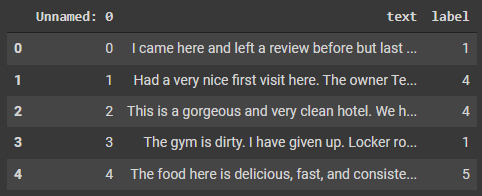

<br>

**Preprocessed Text:**

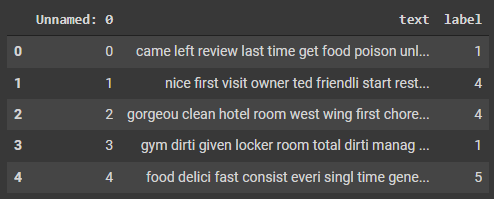

### Preparing the Binary and Multiclass Datasets
For this project, two different datasets created out of this original Train and Test datasets.

#### **Binary Dataset**
Get rid of the class 3 in the dataset and map class 1 and 2 to 0, and class 4 and 5 to 1.

##### *Train:*
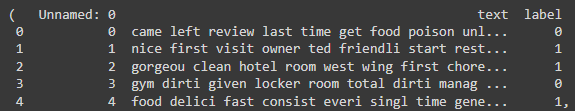

<br>

##### *Test:*
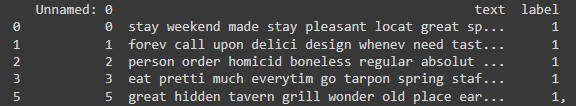

#### **Multiclass Dataset:**
Shift classes to the range 0 to 4. [5 → 4, 4 → 3, 3 → 2, 2 →1, 1 → 0]

##### *Train:*
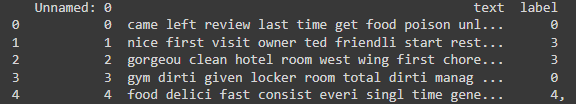

<br>

##### *Test:*
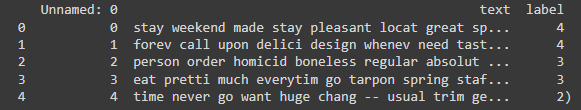

### Text Classification with Naïve Bayes (Non-Neural Model)

#### Initializing the Pipeline and GridSearchCV Parameters
##### Pipeline
The pipeline which will be passed to GridSearchCV consist of three main components which are TfidfVectorizer, DenseTransformer, and Naïve Bayes classifier. Sklearn’s TdidfVectorizer is used for representing data as vectors. The class DenseTransformer is used for converting sparse matrix output of TfidfVectorizer to dense matrix for feeding into classifier. Lastly the classifier that will be used in this part of the project will be GaussianNB.

This pipeline will be applied both for Binary and Multiclass datasets.

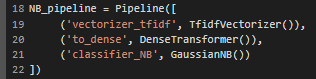

<br>

##### GridSearchCV Parameters
The parameters that will be passed to the GridSearchCV are TfidfVectorizer’s “ngram_range” and “min_df”. N-grams will be up to 3-grams and, since, for a term to be valid it should exist in at least N documents, therefore the min_df values determined as 100, 500, and 1000.

This GridSearchCV parameters will be applied both for Binary and Multiclass datasets.

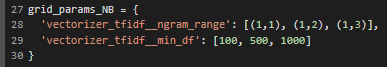

#### Train GridSearchCV with Binary Classification Dataset
GridSearchCV will be trained separately for Binary and Multiclass datasets.

##### Binary
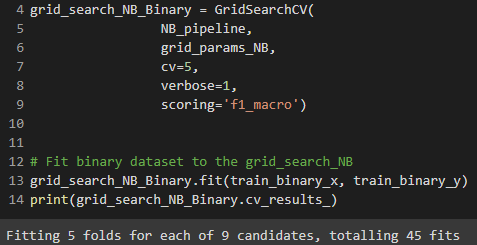
##### Multiclass
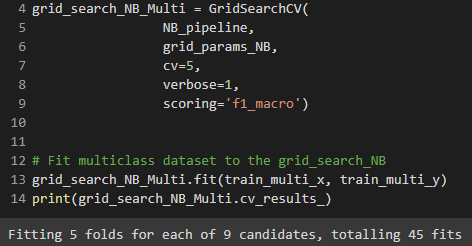

#### Report the Results
Mean Test Score, Standard Deviation Test Score, Min - Max Split Test Scores will be reported for each 9 hyperparameter group. Among these hyperparameter groups, best parameter set for given dataset and hyperparameter space will be selected. In the next step, the best parameters reported for both Binary and Multiclass datasets will used for setting the pipeline again and making predictions.
##### Binary
###### Parameter Groups (First 5)
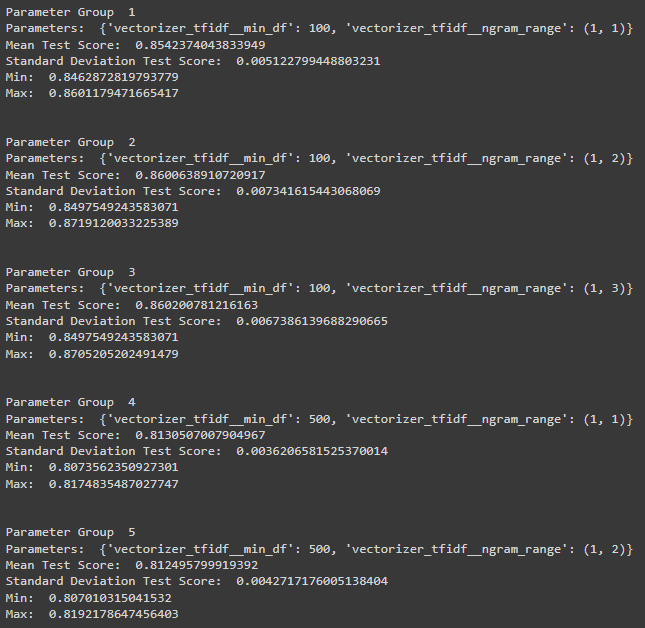
###### Best Parameters
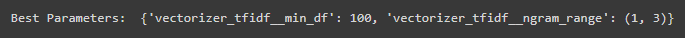

<br>

##### Multiclass
###### Parameter Groups (First 5)
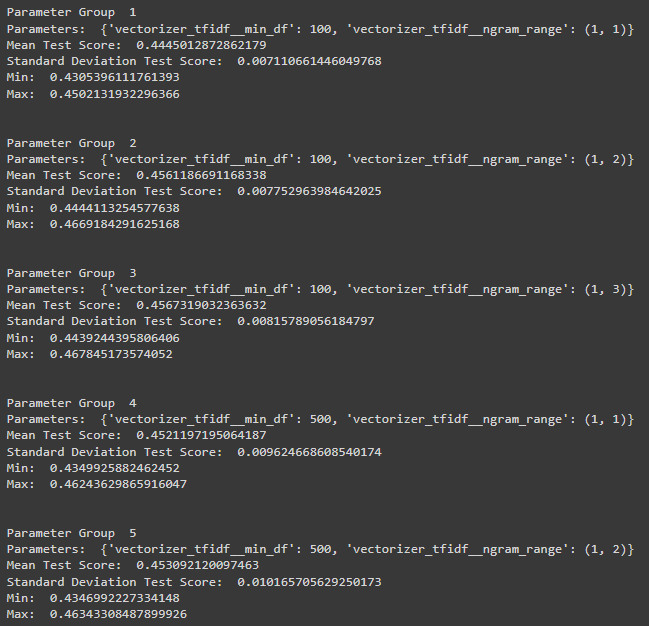
###### Best Parameters
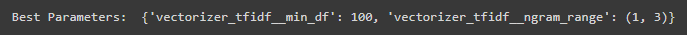

#### Setting Pipeline with Best Parameters / Making Predictions / Reporting the Scores and Confusion Matrix
Best parameters obtained for both Binary and Multiclass datasets will be passed to the pipeline again. These new pipelines will be fitted to the training sets of the each datasets and predictions will be made.
##### Binary
Obtained F1-Macro and Accuracy Scores and Confusion Matrix for the Binary classification.
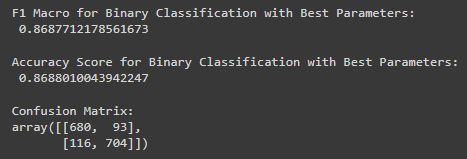
##### Multiclass
Obtained F1-Macro and Accuracy Scores and Confusion Matrix for the Multiclass classification.
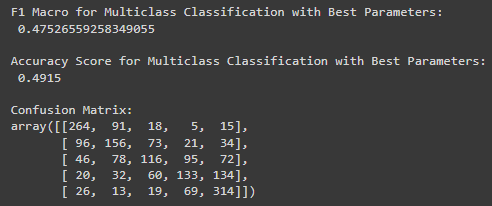

### Text Classification with Logistic Regression (Non-Neural Model)

#### Initializing the Pipeline and GridSearchCV Parameters
##### Pipeline
The pipeline which will be passed to GridSearchCV consist of two main components which are TfidfVectorizer, and Logistic Regression classifier. Sklearn’s TdidfVectorizer is used for representing data as vectors. Lastly the classifier that will be used in this part of the project will be LogisticRegression with random state 22.

This pipeline will be applied both for Binary and Multiclass datasets.

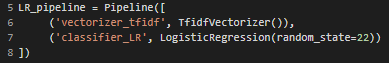

<br>

##### GridSearchCV Parameters
The parameters that will be passed to the GridSearchCV are TfidfVectorizer’s “ngram_range” and “min_df”; and LogisticRegressions “l1_ratio”. N-grams will be up to 3-grams and, since, for a term to be valid it should exist in at least N documents, therefore the min_df values determined as 100, 500, and 1000. Lastly, “l1_ratio” will be used for try different values [0.0, 0.5, 0.1] for regularization distribution between L1 and L2 regularization. For `0 < l1_ratio <1`, the penalty is a combination of L1 and L2. 

- l1_ratio = 0  means using the penalty L2.
- l1_ratio = 1  means using the penalty L1.

This GridSearchCV parameters will be applied both for Binary and Multiclass datasets.

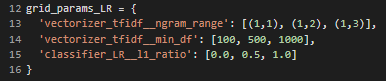

#### Train GridSearchCV with Binary Classification Dataset
GridSearchCV will be trained separately for Binary and Multiclass datasets.

##### Binary
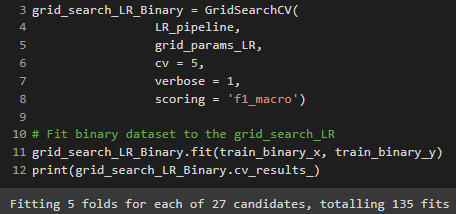
##### Multiclass
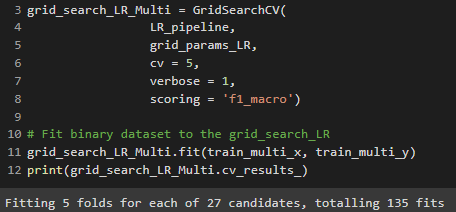

#### Report the Results
Mean Test Score and Standard Deviation Test Score will be reported for each 27 hyperparameter group. Among these hyperparameter groups, best parameter set for given dataset and hyperparameter space will be selected. In the next step, the best parameters reported for both Binary and Multiclass datasets will used for setting the pipeline again and making predictions.
##### Binary
###### Parameter Groups (First 5)
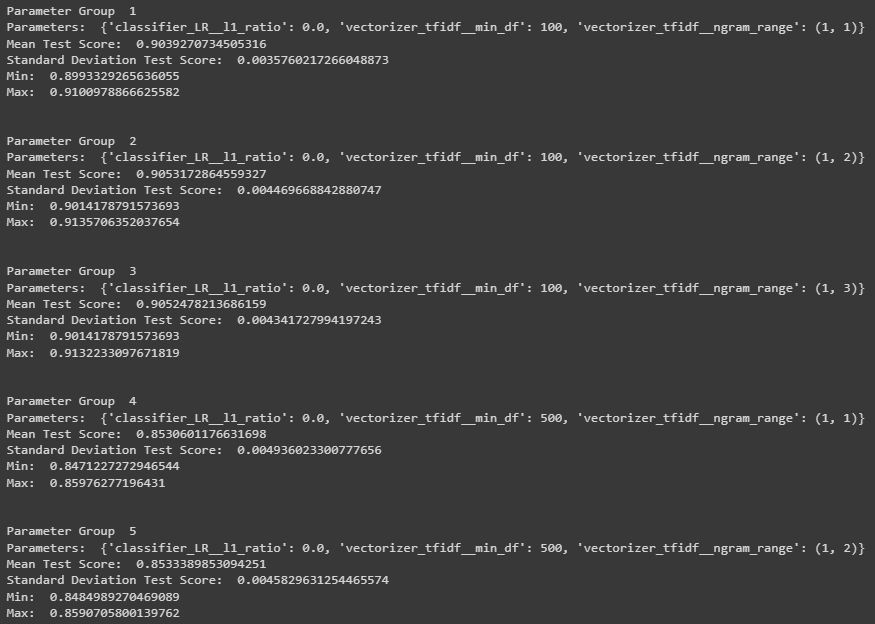
###### Best Parameters
image.png

<br>

##### Multiclass
###### Parameter Groups (First 5)
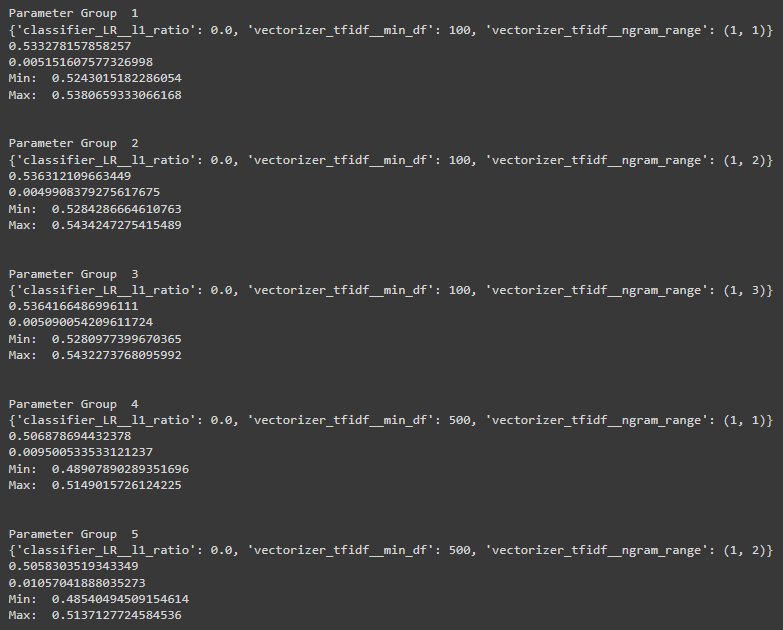
###### Best Parameters
image.png

#### Setting Pipeline with Best Parameters / Making Predictions / Reporting the Scores and Confusion Matrix
Best parameters obtained for both Binary and Multiclass datasets will be passed to the pipeline again. These new pipelines will be fitted to the training sets of the each datasets and predictions will be made.
##### Binary
Obtained F1-Macro and Accuracy Scores and Confusion Matrix for the Binary classification.
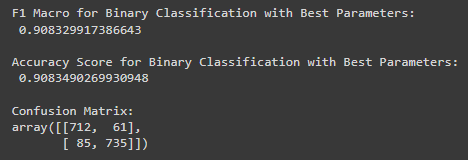
##### Multiclass
Obtained F1-Macro and Accuracy Scores and Confusion Matrix for the Multiclass classification.
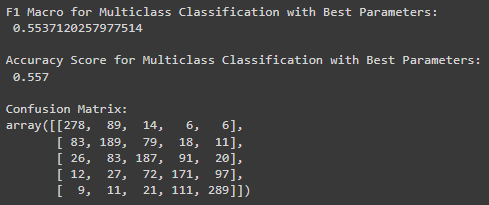

### Text Classification with Convolutional Neural Network (CNN) (Neural Model)

#### Preparing Datasets and Creating the Validation Datasets
A Validation dataset for Binary and Multiclass datasets is created using train_test_split function with random_state=22 and test_size = 0.1.

Additionally, y-values (label) of the train - test - validation multiclass datasets are arranged using to_categorical function.

#### Length of the Longest Sentences
Length of the longest sentences is found 495. This information will be useful in the padding and creating embedding layers stages of the CNN part of this project.

#### Tokenization
In this stage, firstly two different keras Tokenizer() is initialized; one for handling binary datasets, other one for handling multiclass datasets. Secondly, fit_on_text() operation applied on both binary and multiclass train datsets. Lastly, both binary and multiclass train - test - validation datasets tokenized using the keras tokenizers text_to_sequence() function.

#### Padding
Both binary and multiclass train - test - validation datasets padded using the pad_sequence() function which takes the related x-value dataset as its parameter besides padding setted to 'post' and maxlen setted to the length of the longest sentences (MAX_LENGTHSENT).



#### Word Embeddings

##### Script for Getting the F1 Score of the Models
Since, there is no default method written for obtaining the F1 Score for CNN Models. A script obtained from Internet is used in this project. <br>
**Link of the resource (Also added to the References section):**
<br>
https://aakashgoel12.medium.com/how-to-add-user-defined-function-get-f1-score-in-keras-metrics-3013f979ce0d#:~:text=You%20will%20get%20training%20and%20validation%20F1%20score%20after%20each%20epoch.&text=By%20default%2C%20f1%20score%20is,like%20accuracy%2C%20categorical%20accuracy%20etc.

##### Creating Embedding Layers
Two types of layers (Binary and Multiclass) created for each word embedding style.
* Embedding Layer For Randomly Initialized Word Embeddings

  "input_dim" setted as the word count+1 which is obtained from the word_index() function of the keras tokenizer and adding 1 to it. "output_dim" is setted as 100 and "input_length" is setted as the length of the longest sentences (MAX_LENGTH_SENT).
  <br>

* Word2Vec Embedding Layer For Word Embeddings From Scratch

  Word2Vec is used for embedding the "From Scratch" CNN Word Embedding Model. "sentences" is obtained by applying split() method for each entry in the x_train datasets. "min_count" is equal to 1.

  For the embedding layer, "input_dim" is obtained by calling Word2Vec's "vocab" method on the embedding and taking the length of it. "output_dim" is setted as 100 and "input_length" is setted as the length of the longest sentences (MAX_LENGTH_SENT). Lastly, the weights obtained by applying Word2Vec's "vectors" method on the embeddings.
  <br>

* Word2Vec Embedding Layer For Pretrained Word Embeddings

  Word2Vec is used for embedding the "Pretrained" CNN Word Embedding Model. "sentences" is obtained by utilizing the api.load function to download the pretrained  model 'text8'. "min_count" is equal to 1.

  The code for this part is written by using the resorce (Also added to the Reference section): <br> https://radimrehurek.com/gensim/auto_examples/howtos/run_downloader_api.html 

  Lastly, the weights obtained by applying Word2Vec's "vectors" method on the embeddings.

##### Parameter Vectors for Running the Model Functions
To find out the model which provides the best results, different parameters are tested on the models. These parameters are Filter Size, Kernel Size, and Hidden Layer Size.
<br>

* General Parameters: <br> 
filter_size_options = [16, 32] <br>
kernel_size_options = [4, 8] <br>
hidden_layer_options =[10, 20] <br>

<br>

Additional, it is preferred to give "Operation Name" as a parameter to the functions due to indicating the functionality of the models.
<br>

* For Binary Model: <br>
operation_names_binary = ['Random Binary Model', 'From Scratch Binary Model', 'Pretrained Binary Model'] <br>
embedding_layer_binary = [random_emb_layer_binary, my_binary_emb_layer, pretrained_binary_emb_layer]

* For Multiclass Model: <br>
operation_names_multi = ['Random Multiclass Model', 'From Scratch Multiclass Model', 'Pretrained Multiclass Model'] <br>
embedding_layer_multi = [random_emb_layer_multi, my_multi_emb_layer, pretrained_multi_emb_layer]

##### [Scores Obtained From the Binary Model Function](https://colab.research.google.com/drive/1EZV-s018NMnogkJqKR06h15mDXyeyOA4#scrollTo=RGhdjOzmprVM)

#####[ Scores Obtained From the Multiclass Model Function ](https://colab.research.google.com/drive/1EZV-s018NMnogkJqKR06h15mDXyeyOA4#scrollTo=CLQV4J3QrBP1)

### Conclusion
For Binary Classification, results obtained from each model were very good, usually both F1 and Accuarcy Scores are between 90 - 85% .
* Naive Bayes: 86% F1 Score | 86% Accuracy Score
* Logistic Regression: 90% F1 Score | 90% Accuracy Score 
* CNN: 
  * Randomly Initialized Word Embedding Model: <br>
  90 - 87% F1-Accuracy Score (Best Result: Filter Size: 16, Kernel Size: 4, Hidden Layer Size: 10)

  * "From Scratch" Word Embedding Model: <br>
  89 - 86% F1-Accuracy Score (Best Result: Filter Size: 16, Kernel Size: 4, Hidden Layer Size: 20)

  * Pretrained Word Embedding Model: <br>
  90-85% F1-Accuracy Score (Best Result: Filter Size: 32, Kernel Size: 4, Hidden Layer Size: 10)

<br>

For Multiclass Classification, results obtained from each model are not good, usually both F1 and Accuarcy Scores are between 50 - 45% .
* Naive Bayes: 47% F1 Score | 49% Accuracy Score
* Logistic Regression: 55% F1 Score | 55% Accuracy Score 
* CNN: 
  * Randomly Initialized Word Embedding Model: <br>
  49 - 47% F1-Accuracy Score (Best Result: Filter Size: 16, Kernel Size: 8, Hidden Layer Size: 10)

  * "From Scratch" Word Embedding Model: <br>
  49 - 45% F1-Accuracy Score (Best Result: Filter Size: 16, Kernel Size: 4, Hidden Layer Size: 20)

  * Pretrained Word Embedding Model: <br>
  47 - 41% F1 Score | 47 - 43 Accuracy Score (Best Result: Filter Size: 32, Kernel Size: 4, Hidden Layer Size: 20)

<br>

Overall, it can be concluded that:
* Binary Classification provides better accuarcy and F1 Scores compared to Multiclass Classification. (
* For both Binary and Multiclass Classification, Logistic Regression do a very good job.
* In case o CNN, it also provide accurate results as good as Logistic Regression. When the complexity and compilation (execution) time of the CNN considered, Logistic Regression Model is a better option for this project.
* Among the CNN Word Embedding Models, Randomly Initialized Word Embedding Models provide the best results. 


### References
* Script for Getting F1 Scores of the Models: <br>
 https://aakashgoel12.medium.com/how-to-add-user-defined-function-get-f1-score-in-keras-metrics-3013f979ce0d#:~:text=You%20will%20get%20training%20and%20validation%20F1%20score%20after%20each%20epoch.&text=By%20default%2C%20f1%20score%20is,like%20accuracy%2C%20categorical%20accuracy%20etc.



* Pretrained CNN Word Embedding Model Reference: <br>
https://radimrehurek.com/gensim/auto_examples/howtos/run_downloader_api.html
